In [78]:
import os
import torch
import itertools
from transformer import Transformer

N=20
dropout = .5
h=1
dim=120
l=1
f=128
ln_eps=1e-5
ln=False
iter=69000
i=1
deg=5
width=20
folderName = "."
dir_name = os.path.join(folderName,"HYPERPARAM_TESTS2")
seedNum = int(str(i)+str(deg)+str(width))
device = "cuda:0"
rank=0

def rboolf(N, width, deg,seed=None):
    if seed:
        torch.manual_seed(seed)
    coefficients = torch.randn(width).to(device)
    #print("coefficients initial shape: " + str(coefficients.shape) + ", width: " + str(width))
    coefficients = (coefficients-coefficients.mean())/coefficients.pow(2).sum().sqrt()
    
    combs = torch.tensor(list(itertools.combinations(torch.arange(N), deg))).to(device)
    combs = combs[torch.randperm(len(combs))][:width] # Shuffled
    return (coefficients, combs)


(coefs, combs) = rboolf(N, width, deg,seed=seedNum)
model = Transformer(dropout,N, dim, h, l, f, ln_eps,rank,ln)
# Load the state dictionary from a file
#try:
print("trying to load " + str(dir_name+"/model_"+str(iter)+".pt"))
state_dict = torch.load(dir_name+"/model_"+str(iter)+".pt")
model.load_state_dict(state_dict)
model.eval()


trying to load ./HYPERPARAM_TESTS2/model_69000.pt


Transformer(
  (embeddings): Embedding(2, 60)
  (transformer): Sequential(
    (0): AttentionBlock(
      (attn): CustomMHA(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=False)
      )
      (linear): Sequential(
        (0): Linear(in_features=80, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=80, bias=True)
      )
    )
  )
)

In [79]:
import time 
import copy
import random
from pyhessian.hessian import hessian
import numpy as np

def makeBitTensor(x, N):
    y = format(x, "b")
    y = ("0"*(N-len(y))) + y
    return [int(z) for z in list(y)]
    
def get_weight_norm(model):
       total_norm = 0.0
       for p in model.parameters():
           if p.requires_grad:
               param_norm = p.data.norm(2)
               total_norm += param_norm.item() ** 2
       return total_norm ** 0.5
    
def calc_hessian(model, loss_fn, num_samples):
        model.eval().to(device)
        inputs = torch.tensor([random.randint(0, 2**N-1) for _ in range(num_samples)]).to(device)
        targets = func_batch(inputs).to(device)
        data = (inputs, targets)        

        # Estimate using PyHessian -- very good
        hess_mod = hessian(model, loss_fn, data, device=0)
        for param in model.parameters():
            param.grad = None
        top_eigs, top_eigVs = hess_mod.eigenvalues(maxIter = 200)
        print("top eigs: " + str(top_eigs))
        top_eig = top_eigs[0] 
        
        trace = hess_mod.trace()
        return top_eig, np.mean(trace)
    
def func_batch(x):
    binaryTensor = ((torch.tensor([makeBitTensor(y,N) for y in x])-.5)*2)
    comps = []
    #print("self.combs length: " + str(len(self.combs)))
    for elem in combs:
        res = torch.tensor([1]*len(x))
        for e in elem:
            bitCol = binaryTensor[:,e]
            res = torch.mul(res, bitCol)
        comps.append(res)
    comps = torch.transpose(torch.stack(comps),1,0).to(device)
    return torch.matmul(comps, coefs).to(device)

loss_fn = lambda result, targets: (result-targets).pow(2).mean()
    
start_time_hessian = time.time()

top_eig, trace = calc_hessian(copy.deepcopy(model), loss_fn=loss_fn, num_samples= 1000)
print("top eig Hessian: " + str(top_eig)+", trace Hessian: " + str(trace))
weight_norm = 0
weight_norm = get_weight_norm(model)
print("weight norm: " + str(weight_norm))
#weight_norm = torch.linalg.norm(self.model.weight)
top_eig=0
trace = 0
end_time_hessian = time.time()
elapsed_time_hessian = round((end_time_hessian - start_time_hessian)/60,3) 

top eigs: [13424.126953125]
top eig Hessian: 13424.126953125, trace Hessian: 65365.505208333336
weight norm: 52.92743861144146


max data val: 20.551548
t_max: 1.0792719737319065


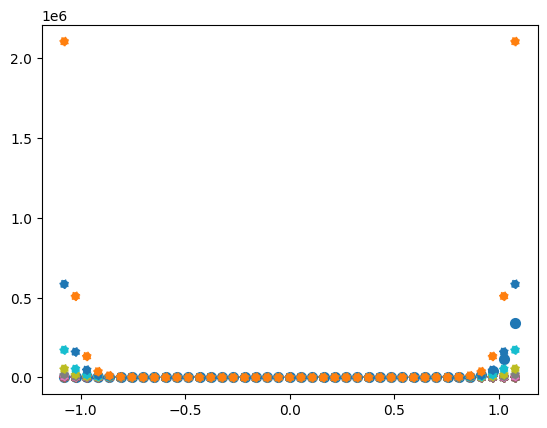

sigma grid: [0.5   0.725 0.95  1.175 1.4   1.625 1.85  2.075 2.3   2.525 2.75  2.975
 3.2   3.425 3.65  3.875 4.1   4.325 4.55  4.775 5.   ]
all_greater: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
lowestInd: (array([19, 20]),)
lowest sigma that upper bounds MGF: 4.7749999999999995


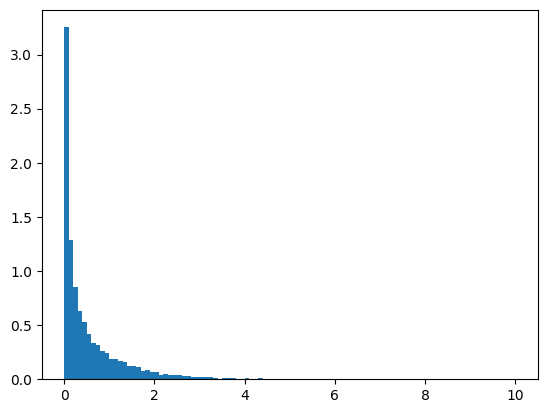

val loss: None


In [153]:
import matplotlib.pyplot as plt


def get_gaussian_mgf(t_arr,sigma):
    result = []
    for t in t_arr:
        result.append(np.exp((sigma**2)*(t**2)/2))
    return np.array(result)

def empirical_mgf(t,data):
    return np.mean(np.exp(t * data))

def get_empirical_mgf_over_t(t_arr,data):
    result=[]
    for t in t_arr:
        result.append(empirical_mgf(t,data))
    return np.array(result)
    
def get_smallest_subgaussian_sigma(n_cells_t,data,min_sigma,max_sigma,n_cells_sigma):
    max_data_val = np.max(data)
    t_max = np.log(2**32-1)/max_data_val
    t_min=-t_max
    print("max data val: " + str(max_data_val))
    print("t_max: " + str(t_max))
    data = data-np.mean(data)
    grid = np.array(range(n_cells_t+1),dtype="float")
    width = t_max-t_min
    mult_factor =grid[-1]/float(width)
    grid/=mult_factor
    shift = t_max-grid[-1]
    grid+=shift
    mgf = get_empirical_mgf_over_t(grid,data)
    sigma_grid = np.array(range(n_cells_sigma+1),dtype="float")
    sigma_width= max_sigma-min_sigma
    mult_factor_sigma = sigma_grid[-1]/float(sigma_width)
    sigma_grid/=mult_factor_sigma
    sigma_shift = max_sigma-sigma_grid[-1]
    sigma_grid+=sigma_shift
    all_greater = [1]*len(sigma_grid)
    plt.scatter(grid,mgf,ls="-",lw=2)

    for j,sigma in enumerate(sigma_grid):   
        gaussian_mgf = get_gaussian_mgf(grid,sigma)
        
        plt.scatter(grid,gaussian_mgf, ls='dotted',lw=1)

        for i in range(len(mgf)):
            if mgf[i]>gaussian_mgf[i]:
                all_greater[j]=0
                break
    plt.show()
    all_greater=np.array(all_greater)
    print("sigma grid: " + str(sigma_grid))   
    print("all_greater: " + str(all_greater))  
    lowestInd = np.nonzero(all_greater)
    print("lowestInd: " + str(lowestInd))
    inds = lowestInd[0]
    if (len(inds)>0):
        lowestSigma =  sigma_grid[inds[0]]
        print("lowest sigma that upper bounds MGF: " + str(lowestSigma))
        return lowestSigma
    else:
        return None
    
def validate( num_samples): 
    model.eval()
    model.to(device)
    inputs = torch.tensor([random.randint(0, 2**N-1) for _ in range(num_samples)]).to(device)
    targets = func_batch(inputs).to(device)
    result = model(inputs).to(device)
    losses = np.array((result - targets).pow(2).detach().cpu())  

    n_cells_t = 40
    min_val_sigma = .5
    max_val_sigma = 5
    n_cells_sigma = 20
    lowest_sigma = get_smallest_subgaussian_sigma(  n_cells_t,
                                                    losses,
                                                    min_val_sigma,
                                                    max_val_sigma,
                                                    n_cells_sigma)
     
    max_bin=10
    n_bins=100
    bins = max_bin*np.array(range(n_bins+1),dtype="float")/n_bins
    #print("bins: " + str(bins))
    hist =  np.histogram(losses, bins, density=True)
    plt.hist(losses,bins, density=True)
    plt.show()
    loss = losses.mean()
    return 
    
val_loss = validate(10000) 
print("val loss: " + str(val_loss))